# Solving the wave equation with a PINN

We aim to solve the simple 1D wave equation:

$$
\frac{\partial^2 u}{\partial t^2} = c^2 \frac{\partial^2 u}{\partial x^2}
$$

This equation can be solved analytically using separation of variables, but we aim to solve it numerically with a PINN, and check that our solution is a sinusoidal wave. To do this, we need the initial conditions:

$$
u(x, 0) = \sin(x)
$$

We will solve the wave equation without boundary conditions, as we assume the wave is a 1D wave of infinite length moving along the $x$ direction, and as such should oscillate forever for $-\infty < x < \infty$.

## Theory

The wave equation can be written in the form $F(x, t) = 0$, where:

$$
F(x, t) = \frac{\partial^2 u}{\partial t^2} - c^2 \frac{\partial^2 u}{\partial x^2}
$$

We want the neural network to learn the solution $u(x, t)$, so we make a general model `model(param, x, t)` that should converge to $u(x, t)$ after training. Thus, given our wave equation, we can define a custom loss function $L(a, x, t)$, where $a$ denotes the matrix of weights and biases:

$$
L(a, x, t) = \frac{1}{n} \sum_{i=0}^n \left( \| F(x, t) \|^2 - \| u(x, t) - z \|^2 \right)
$$

Where $z$ denotes the initial conditions we give to the model. Thus, through the same method of gradient descent, the neural network learns the function $u(x, t)$:

$$
a_{n + 1} = a_n - \gamma \nabla L(a, x, t)
$$

In [2]:
import jax
import jax.numpy as jnp
from jax import jit, grad, vmap
import matplotlib.pyplot as plt

In [122]:
def sigmoid(x):
    return 1.0 / (1.0 + jnp.exp(-x))

In [123]:
# Model with basic sigmoid activation to represent u(x, t)
def model(params, x, t, activation=sigmoid):
    wx = params[:1000] # x weights
    wt = params[1000:2000] # t weights
    b0 = params[2000:3000]
    w1 = params[3000:4000]
    b1 = params[4000]
    h = activation(x*wx + t*wt + b0) # we first create a typical neuron
    o = jnp.sum(h*w1) + b1 # then we sum the neuron output as u(x, t) is a scalar-valued function
    return o

In [124]:
def f(x, y):
    return 2 * x * y ** 2

In [125]:
df_2dx_2 = grad(grad(model, 1), 1) # ∂^2f / ∂x^2
df_2dt_2 = grad(grad(model, 2), 2) # ∂^2f / ∂t^2

In [126]:
model_vect = jit(vmap(model, (None, 0, 0)))
df_2dx_2_vect = jit(vmap(df_2dx_2, (None, 0, 0)))
df_2dt_2_vect = jit(vmap(df_2dt_2, (None, 0, 0)))

In [127]:
samples = 3000

In [128]:
x = jnp.linspace(0, 2 * jnp.pi, samples)
t = jnp.linspace(0, 1, samples)
initial = jnp.sin(x)
zeros = jnp.zeros(samples)

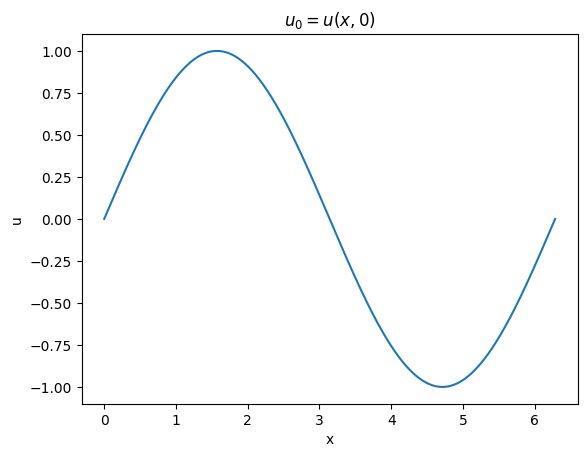

In [132]:
plt.plot(x, initial)
plt.title(r"$u_0 = u(x, 0)$")
plt.xlabel("x")
plt.ylabel("u")
plt.show()

In [133]:
# The PDE (what we refer to as F(x, t))
@jit
def pde(params, x, t, c=1):
    # ∂^2f / ∂t^2 - c^2 (∂^2f / ∂x^2)
    return df_2dt_2_vect(params, x, t) - \
        c ** 2 * df_2dx_2_vect(params, x, t)

In [134]:
def loss(params, x, t, initial=initial, zeros=zeros):
    return jnp.mean(pde(params, x, t) ** 2 \
            + (model_vect(params, x, zeros) - initial) ** 2)

In [135]:
loss_grad = jit(grad(loss, 0))

In [136]:
key = jax.random.PRNGKey(0)

In [151]:
epochs = 7000 #5000
lr = 0.0005

In [152]:
params = jax.random.normal(key, shape=(4001,))

In [153]:
for epoch in range(epochs):
    if epoch % 100  == 0:
        print(f"Epoch: {epoch} loss: {loss(params, x, t)}")
    gradient = loss_grad(params, x, t)
    params -= lr * gradient

Epoch: 0 loss: 27.353967666625977
Epoch: 100 loss: 0.7922347784042358
Epoch: 200 loss: 0.36526280641555786
Epoch: 300 loss: 0.22844372689723969
Epoch: 400 loss: 0.1673049032688141
Epoch: 500 loss: 0.1347435563802719
Epoch: 600 loss: 0.11526741087436676
Epoch: 700 loss: 0.10240288078784943
Epoch: 800 loss: 0.0931054949760437
Epoch: 900 loss: 0.08586037904024124
Epoch: 1000 loss: 0.07988710701465607
Epoch: 1100 loss: 0.07476898282766342
Epoch: 1200 loss: 0.07027404010295868
Epoch: 1300 loss: 0.06626514345407486
Epoch: 1400 loss: 0.06265503913164139
Epoch: 1500 loss: 0.0593847818672657
Epoch: 1600 loss: 0.05640989542007446
Epoch: 1700 loss: 0.0536961555480957
Epoch: 1800 loss: 0.05121465399861336
Epoch: 1900 loss: 0.048941634595394135
Epoch: 2000 loss: 0.046855680644512177
Epoch: 2100 loss: 0.04493885859847069
Epoch: 2200 loss: 0.043174393475055695
Epoch: 2300 loss: 0.04154764860868454
Epoch: 2400 loss: 0.04004595801234245
Epoch: 2500 loss: 0.038657497614622116
Epoch: 2600 loss: 0.0373712

In [154]:
t0 = jnp.zeros(samples)

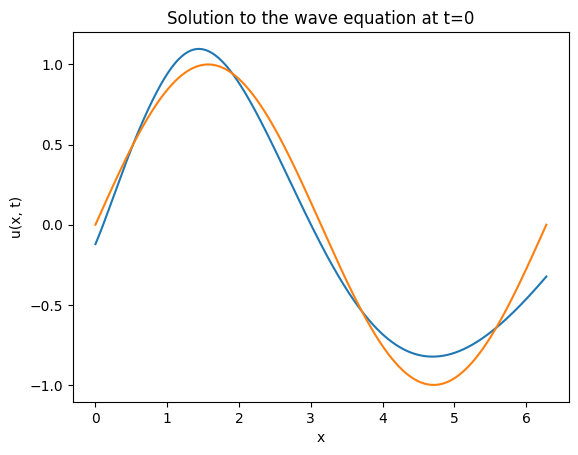

In [155]:
# Plotting the solution at t=0
plt.plot(x, model_vect(params, x, t0))
plt.title("Solution to the wave equation at t=0")
plt.xlabel("x")
plt.ylabel("u(x, t)")
plt.plot(x, initial)
plt.show()

In [156]:
t1 = jnp.ones(samples)

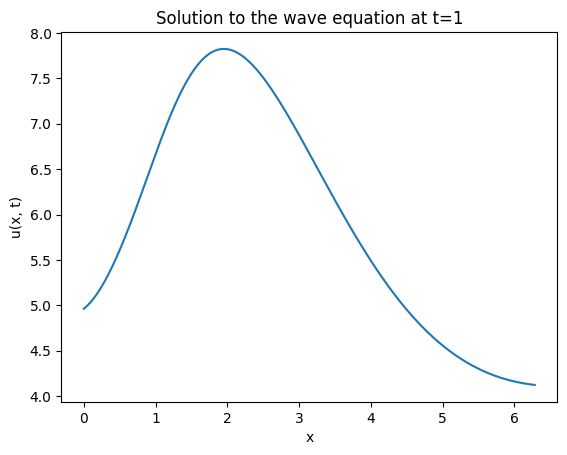

In [157]:
# Plotting the solution at t=1
plt.plot(x, model_vect(params, x, t1))
plt.title("Solution to the wave equation at t=1")
plt.xlabel("x")
plt.ylabel("u(x, t)")
plt.show()